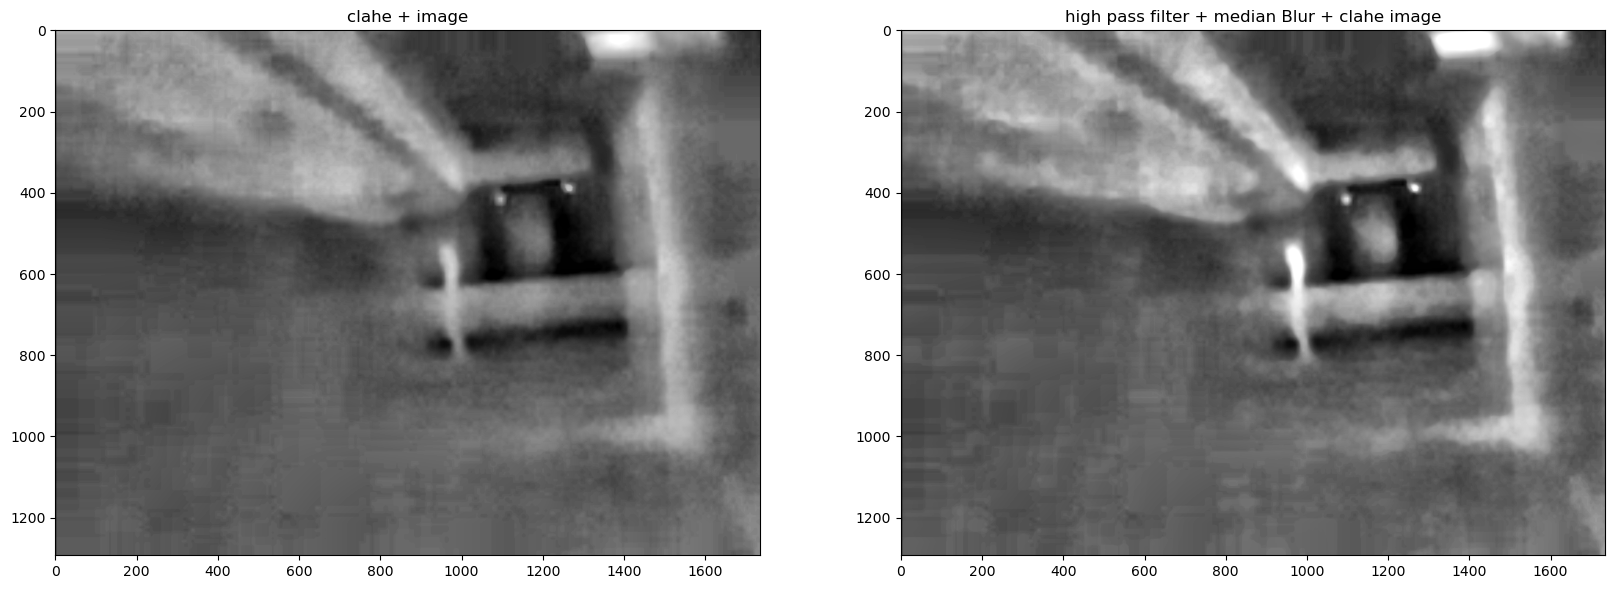

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load thermal image (grayscale)
image = cv2.imread("image.png", cv2.IMREAD_GRAYSCALE)

# Apply CLAHE for local contrast enhancement
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
image_clahe = clahe.apply(image)

original = image
image = image_clahe
equalized = cv2.equalizeHist(image)

# Apply a Gaussian blur (low-pass filter)
low_pass_image = cv2.GaussianBlur(image, (299, 299), 0)
low_pass_image_original = cv2.GaussianBlur(original, (299, 299), 0)

# Subtract the low-pass filtered image from the original to get the high-pass filtered image
high_pass_image = cv2.subtract(image, low_pass_image)
high_pass_image_original = cv2.subtract(original, low_pass_image)

high = cv2.medianBlur(high_pass_image, 25) # high pass filter + median Blur

final2 = cv2.add(image, high) # high pass filter + median Blur + clahe image

plt.figure(figsize=(20,15))

plt.subplot(1,2,1)
plt.imshow(image_clahe, cmap = 'gray')
plt.title("clahe + image")

plt.subplot(1,2,2)
plt.imshow(final2, cmap = 'gray')
plt.title("high pass filter + median Blur + clahe image")

plt.show()

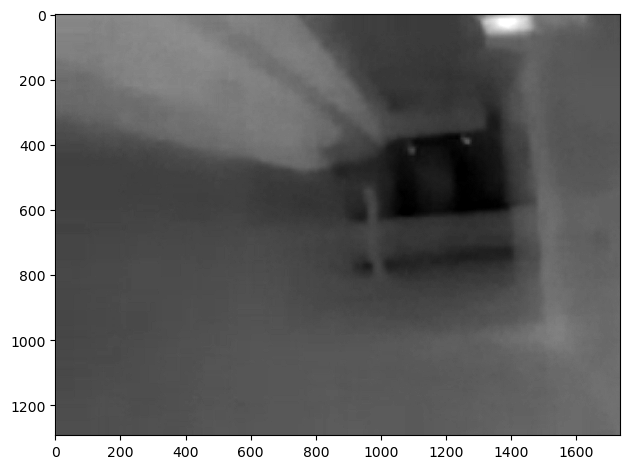

In [7]:
from skimage import filters, io
image = io.imread('image.png', as_gray=True)
sharp_image = filters.unsharp_mask(image, radius=1, amount=2)
io.imshow(sharp_image)


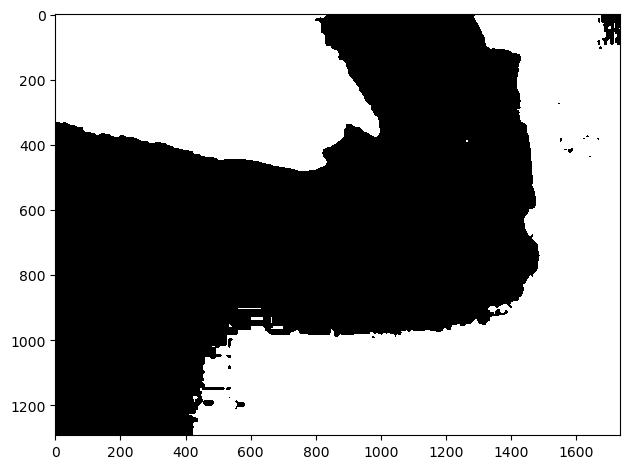

In [8]:
from skimage.filters import threshold_otsu
threshold = threshold_otsu(image)
binary = image > threshold
io.imshow(binary)


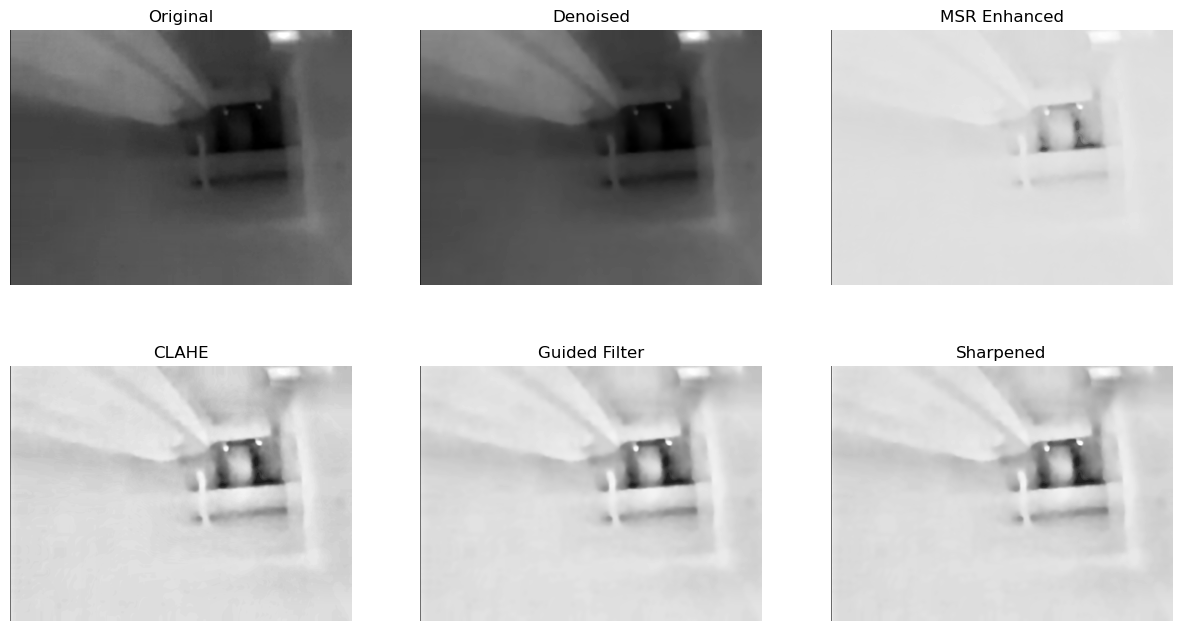

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration, exposure
from cv2.ximgproc import guidedFilter  # Requires OpenCV contrib module

# Load the thermal image in grayscale
image_path = "image.png"  # Ensure the image is in the same directory
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 1. Denoising using Non-Local Means
denoised = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)

# 2. Multi-Scale Retinex (MSR) Enhancement
def multi_scale_retinex(img, sigma_list=[15, 80, 250]):
    retinex = np.zeros_like(img, dtype=np.float32)
    for sigma in sigma_list:
        blurred = cv2.GaussianBlur(img, (0, 0), sigma)
        retinex += np.log1p(img + 1e-6) - np.log1p(blurred + 1e-6)
    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex)) * 255
    return np.uint8(retinex)

msr_result = multi_scale_retinex(denoised)

# 3. Contrast Enhancement using CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
contrast_enhanced = clahe.apply(msr_result)

# 4. Edge-Preserving Smoothing using Guided Filter
guided = guidedFilter(contrast_enhanced, contrast_enhanced, radius=8, eps=50)

# 5. Sharpening using Unsharp Masking
sharpened = cv2.addWeighted(guided, 1.5, cv2.GaussianBlur(guided, (0, 0), 3), -0.5, 0)

# Display Results
titles = ["Original", "Denoised", "MSR Enhanced", "CLAHE", "Guided Filter", "Sharpened"]
images = [image, denoised, msr_result, contrast_enhanced, guided, sharpened]

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")

plt.show()
